# https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag_local/

In [1]:
local_llm = "llama3"
model_tested = "llama3-8b"
metadata = f"CRAG, {model_tested}"

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings  # local

from dotenv import load_dotenv
load_dotenv()

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

import uuid
from langsmith import Client
from langchain import hub
from langchain_openai import ChatOpenAI
from langsmith.schemas import Example, Run
from langsmith.evaluation import evaluate

In [3]:
# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Embedding
embedding=NomicEmbeddings(
    model="nomic-embed-text-v1.5",
    inference_mode="local",
)

# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

In [4]:
### Retrieval Grader
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

{'score': 1}


In [5]:
### Generate

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

According to the documents, agent memory refers to the long-term memory module that records a comprehensive list of agents' experience in natural language. This allows the agent to retain and recall information over extended periods.


In [6]:
web_search_tool = TavilySearchResults(k=3)

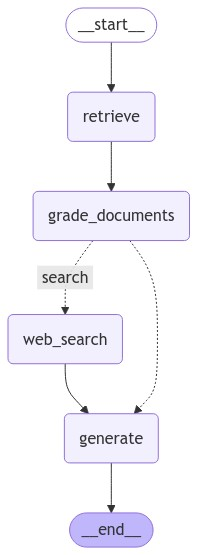

In [7]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(example)
response

{'response': "According to the documents, there are two main categories of agent memory:\n\n* Short-term Memory: This allows agents to utilize short-term memory of large language models to operate on original problems.\n* Long-term Memory (LTM): This has three subcategories:\n\t+ Procedural memory: represents the agent's procedures for thinking, acting, and decision-making.\n\nNote that there is no mention of episodic or semantic memory in these documents.",
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

In [9]:
client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection? ",
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs.",
    ),
    (
        "What are the types of biases that can arise with few-shot prompting?",
        "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias.",
    ),
    (
        "What are five types of adversarial attacks?",
        "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming.",
    ),
    (
        "Who did the Chicago Bears draft first in the 2024 NFL draft”?",
        "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft.",
    ),
    ("Who won the 2024 NBA finals?", "The Boston Celtics on the 2024 NBA finals"),
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

In [19]:
# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = ChatOllama(model=local_llm, temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

In [20]:
# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]


def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned
    """
    tool_calls = [tc['name'] for m in messages['messages'] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls


def check_trajectory_react(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    messages = root_run.outputs["messages"]
    tool_calls = find_tool_calls_react(messages)
    print(f"Tool calls ReAct agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}


def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [21]:
experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_local_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=1,  # Use when running locally
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'custom-agent-llama3-8b-answer-and-tool-use-38ceb638' at:
https://smith.langchain.com/o/fb28be30-d3ba-59e8-9a35-172eba072515/datasets/20eab020-fb71-4c59-9e6d-7c9ffd828855/compare?selectedSessions=b38b79ff-c859-461a-bb19-d2a3ee1477d9




0it [00:00, ?it/s]

Error running evaluator <DynamicRunEvaluator answer_evaluator> on run ea53f45b-e585-46f4-95a2-53090b27b4e3: NotImplementedError()
Traceback (most recent call last):
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1345, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 327, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/run_helpers.py", line 646, in wrapper
    raise e
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/run_helpers.py", line 643, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


Error running evaluator <DynamicRunEvaluator answer_evaluator> on run f5ea38f5-a8ca-47a1-bb58-b896f25a40ed: NotImplementedError()
Traceback (most recent call last):
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1345, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
                         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/evaluation/evaluator.py", line 327, in evaluate_run
    result = self.func(
             ^^^^^^^^^^
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/run_helpers.py", line 646, in wrapper
    raise e
  File "/Users/yoshitakainoue/miniconda3/envs/multi/lib/python3.11/site-packages/langsmith/run_helpers.py", line 643, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


KeyboardInterrupt: 

# Not implementation error was occured.